# 🐱 Cat Breed Explorer: Multimodal Search with CLIP + ChromaDB 🐾
Welcome to the Cat Breed Explorer!

This is an interactive demo that showcases the power of **multimodal search** using **CLIP embeddings**, **ChromaDB**, and **LLMs**.

**In this notebook, we'll explore**:

* 🧠 ChromaDB as a Vector Store: Efficient storage and retrieval of CLIP embeddings with metadata.

* 🔍 Text-to-Image Search: Type a phrase like “a long-haired orange cat” and get images of matching breeds.

* 📸 Image-to-Text Search: Upload an image of a cat, and retrieve breed descriptions that match it.

* 📚 LLM-Powered Q&A: Ask natural language questions about breeds (e.g. “Which cat is the most affectionate?”), and get friendly, detailed answers based on retrieved context.

This is a fun and educational demo built to show how you can combine vector similarity, RAG (Retrieval-Augmented Generation), and multimodal reasoning in a real-world use case — all through the lens of adorable felines 🐱.


**Important Notes** 
* The data used in this notebook is pulled from the [CatAPI](https://developers.thecatapi.com/view-account/ylX4blBYT9FaoVd6OhvR?report=bOoHBz-8t).
If you do not have an API Key and do not wish to create one, uncomment the block
of code where you can download the json file from my [GitHub](www.github.com/Gabya06/cat_breeds).
* You **need** an API Key for [GoogleAI](https://ai.google.dev/gemini-api/docs/api-key) to be able to run this notebook.

In [1]:
!pwd

/Users/gabyagrocostea/dev/cat_breeds/notebooks


In [2]:
cd ..

/Users/gabyagrocostea/dev/cat_breeds


/Users/gabyagrocostea/dev/cat_breeds/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
!pip install chromadb==1.0.3

  Using cached chromadb-1.0.3-cp39-abi3-macosx_11_0_arm64.whl.metadata (6.9 kB)
  Using cached build-1.2.2.post1-py3-none-any.whl.metadata (6.5 kB)
  Using cached pydantic-2.11.3-py3-none-any.whl.metadata (65 kB)
  Using cached chroma_hnswlib-0.7.6.tar.gz (32 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached fastapi-0.115.9-py3-none-any.whl.metadata (27 kB)
  Using cached uvicorn-0.34.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached numpy-2.2.4-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached posthog-3.24.1-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached onnxruntime-1.21.0-cp313-cp313-macosx_13_0_universal2.whl.metadata (4.5 kB)
  Using cached opentelemetry_api-1.32.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached opentelemetry_exporter_otlp_proto_grpc-1.32.0-py3-none-any.whl.metad

In [3]:
!pip install -e .

Obtaining file:///Users/gabyagrocostea/dev/cat_breeds
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached chromadb-1.0.3-cp39-abi3-macosx_11_0_arm64.whl.metadata (6.9 kB)
  Using cached google_genai-1.7.0-py3-none-any.whl.metadata (32 kB)
  Using cached openai-0.27.2-py3-none-any.whl.metadata (13 kB)
  Using cached transformers-4.45.2-py3-none-any.whl.metadata (44 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached safetensors-0.5.3-cp38-abi3-macosx_11_0_arm64.whl.metadata (3.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any

In [5]:
from io import BytesIO
import os

from dotenv import load_dotenv
from google import genai
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import  tqdm

In [7]:
from cat_breeds import (CatDataProcessor,
                        CatBreedQA,
                        ClipMatcher,
                        CatImageGeenerator)
from cat_breeds.utils.embedding_functions import (ClipTextEmbeddingFunction,
                                                  ClipImageEmbeddingFunction)
from cat_breeds.utils import utils

In [8]:
load_dotenv()
# load Gemini API Key
api_key = os.getenv("GEMINI_API_KEY")
client = genai.Client(api_key=api_key)

## 🐱 1. Fetch Cat Breed Metadata + Images

This section pulls data from the CatAPI and download images in the `images` folder

If you dont have a CATAPI Key uncomment this and download the data from my git
and comment out the first 2 lines in the next cell

In [ ]:
# !wget "https://raw.githubusercontent.com/Gabya06/cat_breeds/refs/heads/main/data/breed_data.json" breeds_data.json
# try:
#   breeds_df = pd.read_json('breed_data.json')
# except Exception as e:
#   print(f"Error downloading breed_data.json from GitHub: {e}")

In [9]:
!pwd

/Users/gabyagrocostea/dev/cat_breeds


In [10]:
breeds_data = CatDataProcessor.get_breeds()

# Convert the data into a DataFrame for easy processing
breeds_df = pd.DataFrame(breeds_data)

# Organize data
breeds_df = breeds_df[['id', 'name', 'origin', 'temperament', 'description',
                       'hypoallergenic','shedding_level', "life_span",
                       'affection_level' , 'health_issues', 'image']]
breeds_df['image_url'] = breeds_df['image'].apply(lambda x: x['url'] if pd.notna(x) else None)

In [11]:
breeds_df.head(2)

,id,name,origin,temperament,description,hypoallergenic,shedding_level,life_span,affection_level,health_issues,image,image_url
0,abys,Abyssinian,Egypt,"Active, Energetic, Independent, Intelligent, G...","The Abyssinian is easy to care for, and a joy ...",0,2,14 - 15,5,2,"{'id': '0XYvRd7oD', 'width': 1204, 'height': 1...",https://cdn2.thecatapi.com/images/0XYvRd7oD.jpg
1,aege,Aegean,Greece,"Affectionate, Social, Intelligent, Playful, Ac...",Native to the Greek islands known as the Cycla...,0,3,9 - 12,4,1,"{'id': 'ozEvzdVM-', 'width': 1200, 'height': 8...",https://cdn2.thecatapi.com/images/ozEvzdVM-.jpg


## 🐾 2. Download Cat Images

In [12]:
images_paths = []
# download images
for row in breeds_data:
    breed_id = row['id']
    breed_name = row['name']
    try:
        # CatDataProcessor.download_images_per_breed(breed_id=breed_id,
        #                                        breed_name=breed_name, num_images=1)

        image = os.listdir(f'images/{breed_name}')[0]
        images_paths.append(image)
    except Exception as e:
        print(e)
        images_paths.append(None)

list index out of range


In [13]:
# process data for RAG Q&A
data = CatDataProcessor.process_data_for_rag(breeds_df)

# Keep important information
data = data[['id','breed','origin','affection_level', 'shedding_level', 'health_issues' ,
             'life_span_avg', 'image_url','cat_description']]

# assign image path
data['image_path'] = images_paths # data.assign(image_path = images_paths)
data.dropna(subset=['image_path'], inplace = True)
data.image_path = data.apply(lambda x: f'images/{x["image_path"].split("_")[0]}/{x["image_path"]}', axis=1)

In [14]:
data.head()

,id,breed,origin,affection_level,shedding_level,health_issues,life_span_avg,image_url,cat_description,image_path
0,abys,Abyssinian,Egypt,very affectionate,shed,have few health issues,14.5,https://cdn2.thecatapi.com/images/0XYvRd7oD.jpg,"The Abyssinian is easy to care for, and a joy ...",images/Abyssinian/Abyssinian_1.jpg
1,aege,Aegean,Greece,affectionate,shed an average amount,have no health issues,10.5,https://cdn2.thecatapi.com/images/ozEvzdVM-.jpg,Native to the Greek islands known as the Cycla...,images/Aegean/Aegean_1.jpg
2,abob,American Bobtail,United States,very affectionate,shed an average amount,have no health issues,13.0,https://cdn2.thecatapi.com/images/hBXicehMA.jpg,American Bobtails are loving and incredibly in...,images/American Bobtail/American Bobtail_1.jpg
3,acur,American Curl,United States,very affectionate,shed an average amount,have no health issues,14.0,https://cdn2.thecatapi.com/images/xnsqonbjW.jpg,Distinguished by truly unique ears that curl b...,images/American Curl/American Curl_1.jpg
4,asho,American Shorthair,United States,very affectionate,shed an average amount,have some health issues,16.0,https://cdn2.thecatapi.com/images/JFPROfGtQ.jpg,The American Shorthair is known for its longev...,images/American Shorthair/American Shorthair_1...


In [15]:
data.shape

(66, 10)

## 🧠 3. Generate Embeddings for Text and Images using CLIP

In [16]:
# Generate CLIP embeddings for images and breed descriptions
embedding_documents = []
image_embeddings = []
text_embeddings = []
metadatas = []

# Loop through each row and generate embeddings for the image & cat_description
for idx, row in tqdm(data.iterrows(), total = len(data)):
    image_path = row['image_path']
    text = row['cat_description']

    image_embedding = ClipMatcher.preprocess_image(image_path=image_path) # preprocess image
    text_embedding = ClipMatcher.preprocess_text(text_list=[text]) # preprocess text

    if image_embedding is not None:
        embedding_documents.append(f"Image: {row['breed']}")  # Document description for image db
        image_embeddings.append(image_embedding)
        text_embeddings.append(text_embedding)

        # Add breed metadata
        breed_metadata = {
            "breed": row["breed"],
            "origin": row["origin"],
            "affection_level": row["affection_level"],
            "health_issues": row["health_issues"],
            "shedding_level": row["shedding_level"]
        }
        metadatas.append(breed_metadata)

100%|██████████| 66/66 [00:14<00:00,  4.50it/s]


In [16]:
# Verify lengths match across documents and embeddings
len(embedding_documents), len(image_embeddings), len(metadatas), len(text_embeddings)

(66, 66, 66, 66)

In [17]:
assert len(embedding_documents) == len(image_embeddings) == len(metadatas) == len(text_embeddings), 'Embedding sizes must equal document size'

## 💾 4. Store in ChromaDB (Embeddings + Vector Search)

Create 2 collections:
* One for cat description text storing CLIP text embeddings - so that we can query text
* One for cat images storing CLIP image embeddings - so that we can query using images

In [17]:
import chromadb
from typing import List
def create_chromadb(
    db_name: str, metadatas: List, embedding_function, delete_exisiting: bool = True
):
    """
    Create ChromaDB collection with given name and embedding function.

    Parameters
    ----------
    db_name : str
        Name of the ChromaDB collection.
    metadatas : List
        Metadata associated with each document.
    embedding_function : EmbeddingFunction
        Function to generate embeddings.
    delete_exisiting: Bool
        Whether to delete exisiting chromaDB before adding documents. Defaults to True
    """

    # create db and include metadata
    chroma_client = chromadb.Client()
    # chroma_client = chromadb.Client(persist_directory="./my_chroma_db")
    # delete existing collection
    if delete_exisiting:
        try:
            chroma_client.delete_collection(name=db_name)
        except Exception:
            pass
    # db = chroma_client.create_collection(name=db_name, embedding_function=embedding_function)
    db = chroma_client.get_or_create_collection(
        name=db_name, embedding_function=embedding_function
    )

    return db

In [18]:
# create text and image collections (Databases) using CLIP embeddings functions
text_embedding_fn = ClipTextEmbeddingFunction()
text_collection = utils.create_chromadb(db_name="cat_breed_texts", 
                                        embedding_function=text_embedding_fn,
                                        )
                                # metadatas=metadatas)

image_embedding_fn = ClipImageEmbeddingFunction()
image_collection = utils.create_chromadb(db_name="cat_breed_images", 
                                         embedding_function=image_embedding_fn,
                                         )
                                #  metadatas=metadatas)


/var/folders/y4/8c0n8_2x5fq9rd9gn92lqkvm0000gn/T/ipykernel_76881/1620556298.py:2: DeprecationWarning: The class ClipTextEmbeddingFunction does not implement __init__. This will be required in a future version.
  text_embedding_fn = ClipTextEmbeddingFunction()
/var/folders/y4/8c0n8_2x5fq9rd9gn92lqkvm0000gn/T/ipykernel_76881/1620556298.py:8: DeprecationWarning: The class ClipImageEmbeddingFunction does not implement __init__. This will be required in a future version.
  image_embedding_fn = ClipImageEmbeddingFunction()


In [19]:
text_collection.peek(1)

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'included': ['embeddings', 'metadatas', 'documents'],
 'data': None,
 'metadatas': []}

In [20]:
# add metadata information to facilitate filtering
metadatas = [
    {
        "breed": row["breed"],
        "origin": row["origin"],
        "affection_level": row["affection_level"],
        "health_issues": row["health_issues"],
        "shedding_level": row["shedding_level"]
    }
    for _, row in data.iterrows()
]

In [21]:
# add documents and text embeddings to text collection
text_collection.add(
    documents=[row['cat_description'] for _, row in data.iterrows()],
    ids=[str(idx) for idx in range(len(data))],
    embeddings=text_embeddings,
    metadatas=metadatas
)

In [22]:
# add documents and image embeddings to image collection
image_collection.add(
    documents=[f"Image: {row['breed']}" for _, row in data.iterrows()],
    ids=[str(idx) for idx in range(len(data))],
    embeddings=image_embeddings,
    metadatas=metadatas
)


In [23]:
# let s take a look at text db ids
text_collection.peek(10)['ids']

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
# look at embeddings shape - should match clip's 512
image_collection.peek(1)['embeddings'].shape

(1, 512)

## 😸 5. Let's explore our images and text information about cats! 👀



In [25]:
# Create cat QA
cat_qa = CatBreedQA(text_db=text_collection, image_db=image_collection,
                    data=data,client=client)

#### 🐱 RAG: Ask "What is the most affectionate cat?"

In [26]:
question_1 = "what cat is the most affectionate?"

In [27]:
results_1 = cat_qa.query(query=question_1, mode='text', n_results=2)

### Results Inspection: 👓

* Ids corresponding to query results in our data. Notice that since we asked for 5 results back we get back 5 ids
* Documents corresponding to cat_description in our data
* Metadata of results
* Distances: these are the euclidean distances between each result and the query

In [28]:
results_1

{'ids': [['24', '42']],
 'embeddings': None,
 'documents': [['The Cymric is a placid, sweet cat. They do not get too upset about anything that happens in their world. They are loving companions and adore people. They are smart and dexterous, capable of using his paws to get into cabinets or to open doors. Their temperament is described as Gentle, Loyal, Intelligent, Playful. They are known to be very affectionate, tend to shed a lot more and have some health issues. They typically live around 11.0 years.',
   'The Munchkin is an outgoing cat who enjoys being handled. She has lots of energy and is faster and more agile than she looks. The shortness of their legs does not seem to interfere with their running and leaping abilities. Their temperament is described as Agile, Easy Going, Intelligent, Playful. They are known to be very affectionate, tend to shed an average amount and have some health issues. They typically live around 12.5 years.']],
 'uris': None,
 'included': ['metadatas', '

### Generate Final Answer using LLM (GEMINI) ✔

In [29]:
# Get LLM to provide the final answer
print(cat_qa.get_answer())

Both the Cymric and Munchkin breeds are known to be very affectionate cats. The Cymric has a gentle, loyal, intelligent, and playful temperament, and the Munchkin is agile, easy going, intelligent and playful. So, it's really up to your personal preference as a cat lover.



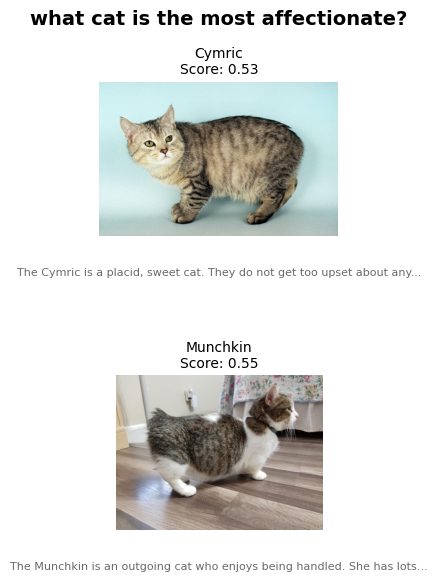

In [30]:
# Display the most affectionate cats!
cat_qa.display()

## Text to Image Query

#### 🐱 RAG: Ask "A long haired white cat"

In [35]:
question_2 = "A long haired white cat with no health issues"

In [36]:
results_2 = cat_qa.query(query=question_2,
                         mode='text_to_image')

### Results inspection

In the below results we can see that we do not obtain the same information in
documents, since this uses the text embedding as a look up in the image collection. 

In this way, the query compares 'long haired cat' with the document text in the image collection ('an image of a Siberian') which is anchored to those images using CLIP.

In [37]:
results_2

{'ids': [['64', '11', '33']],
 'embeddings': None,
 'documents': [['Image: Turkish Van', 'Image: Birman', 'Image: Himalayan']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'health_issues': 'have no health issues',
    'shedding_level': 'shed an average amount',
    'affection_level': 'very affectionate',
    'breed': 'Turkish Van',
    'origin': 'Turkey'},
   {'shedding_level': 'shed an average amount',
    'breed': 'Birman',
    'origin': 'France',
    'health_issues': 'have no health issues',
    'affection_level': 'very affectionate'},
   {'affection_level': 'very affectionate',
    'shedding_level': 'shed a lot',
    'origin': 'United States',
    'breed': 'Himalayan',
    'health_issues': 'have some health issues'}]],
 'distances': [[1.4024943113327026, 1.4126797914505005, 1.4242392778396606]]}

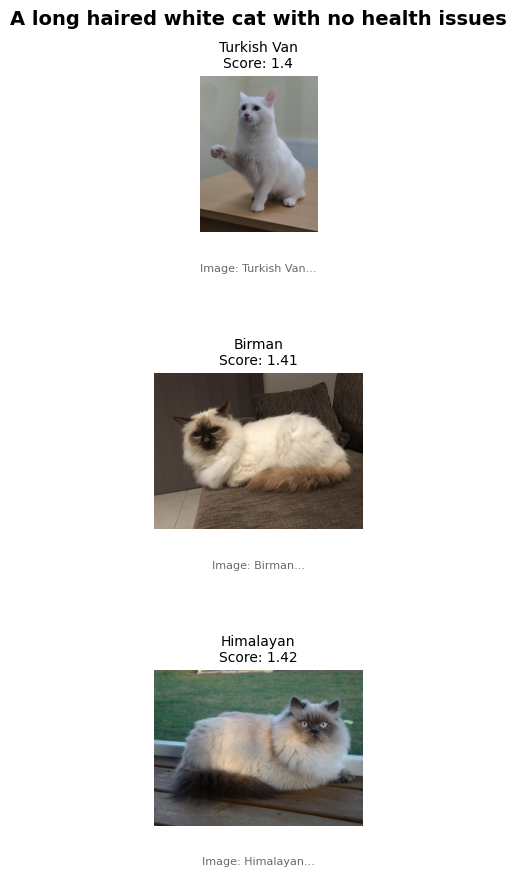

In [38]:
cat_qa.display()

### Ask Gemini for the final answer

In [39]:
print(cat_qa.get_answer())

Based on the images you sent, I can offer some information about three cat breeds that might suit your preference for a long-haired white cat. 

First, we have the Turkish Van, which is a striking breed known for its predominantly white coat and colored markings on the head and tail. They are also known to be a healthy breed overall.

Next, we have the Birman, which is a beautiful cat breed known for its silky, long coat, blue eyes, and gentle temperament. It is also a relatively healthy breed.

Lastly, the Himalayan cat is another long-haired breed with a white or cream-colored coat and distinct color points. While generally healthy, they can be prone to certain genetic conditions.



## 🐾  6. Image Matching - Cat Discovery 😼

In this section, I test out a few photos of my cats and match them with the images in the cat database.


#### What type of cat is it?

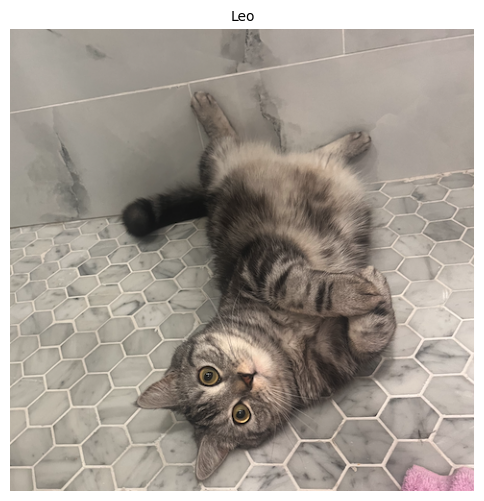

In [40]:
new_image_path = 'images/my_pets/leo_1.png'

fig, ax = plt.subplots(figsize=(8,6))
img = Image.open(new_image_path)

ax.imshow(img)
ax.set_title(f"Leo", fontsize=10)
ax.axis('off')
plt.show(fig)

In [41]:
# embed Leo's picture
new_image_embeddings = ClipMatcher.preprocess_image(new_image_path)

In [42]:
results_3 = cat_qa.query(query='What kind of cat is this?', mode='image',
                         image_path=new_image_path, n_results=2)

In [43]:
print(cat_qa.get_answer())

I can help with that! Based on the images I have, the cat breeds shown are the Scottish Fold and the Savannah.



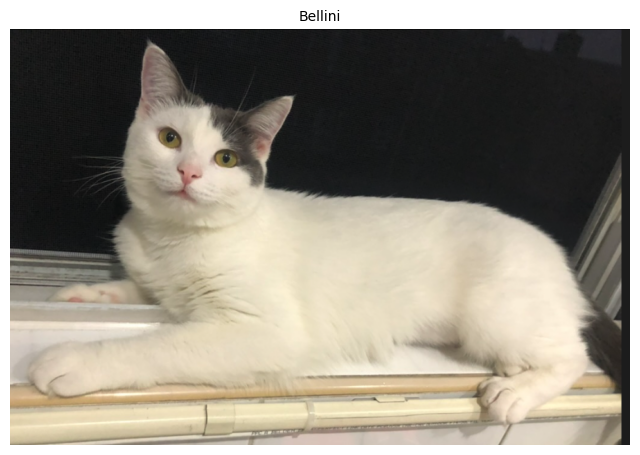

In [44]:
new_image_path_2 = 'images/my_pets/bellini_1.png'

fig, ax = plt.subplots(figsize=(8,6))
img = Image.open(new_image_path_2)

ax.imshow(img)
ax.set_title(f"Bellini", fontsize=10)
ax.axis('off')
plt.show(fig)

In [45]:
# embed Leo's picture
new_image_embeddings_2 = ClipMatcher.preprocess_image(new_image_path_2)

In [48]:
results_4 = cat_qa.query(query='What kind of cat is this?', mode='image',
                         image_path=new_image_path_2, n_results=2)

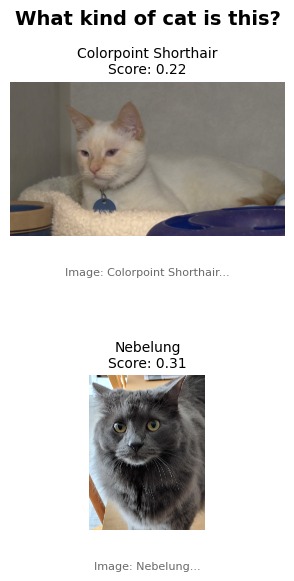

In [49]:
cat_qa.display()

In [50]:
print(cat_qa.get_answer())

Based on the reference images, I can see two cat breeds: a Colorpoint Shorthair and a Nebelung. Hopefully that helps!



In [51]:
results_4

{'ids': [['22', '43']],
 'embeddings': None,
 'documents': [['Image: Colorpoint Shorthair', 'Image: Nebelung']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'shedding_level': 'shed an average amount',
    'health_issues': 'have few health issues',
    'affection_level': 'affectionate',
    'breed': 'Colorpoint Shorthair',
    'origin': 'United States'},
   {'origin': 'United States',
    'breed': 'Nebelung',
    'shedding_level': 'shed an average amount',
    'health_issues': 'have few health issues',
    'affection_level': 'very affectionate'}]],
 'distances': [[0.221917986869812, 0.3107975125312805]]}

## 🧩 6. Image Matching (CLIP Similarity)

In this section, I used cosine similarity between text embeddings and an image embeddings to 
predict the cat breed.


In [65]:
import torch

In [85]:
predicted_breeds = []

In [83]:
predicted_breed = ClipMatcher.predict_breed(
    breed_names=data.breed.tolist(),
    text_embeddings=torch.tensor(text_embeddings),
    image_embedding=torch.tensor(new_image_embeddings)
)

In [86]:
predicted_breeds.append(predicted_breed)
print(f"Leo's predicted breed is {predicted_breed}.")

Leo's predicted breed is Scottish Fold.


In [64]:
cat_qa.query(query=f'What is a {predicted_breed}', mode='text', n_results=1)

{'ids': [['53']],
 'embeddings': None,
 'documents': [['The Scottish Fold is a sweet, charming breed. She is an easy cat to live with and to care for. She is affectionate and is comfortable with all members of her family. Her tail should be handled gently. Folds are known for sleeping on their backs, and for sitting with their legs stretched out and their paws on their belly. This is called the "Buddha Position". Their temperament is described as Affectionate, Intelligent, Loyal, Playful, Social, Sweet, Loving. They are known to be very affectionate, tend to shed an average amount and can have health issues. They typically live around 12.5 years.']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'origin': 'United Kingdom',
    'shedding_level': 'shed an average amount',
    'health_issues': 'can have health issues',
    'breed': 'Scottish Fold',
    'affection_level': 'very affectionate'}]],
 'distances': [[0.5299165844917297]]}

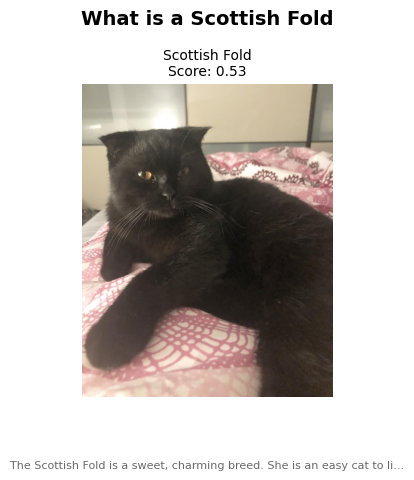

In [57]:
cat_qa.display()

In [87]:
predicted_breed_2 = ClipMatcher.predict_breed(
    breed_names=data.breed.tolist(),
    text_embeddings=torch.tensor(text_embeddings),
    image_embedding=torch.tensor(new_image_embeddings_2)
)
print(f"Bellini's predicted breed is {predicted_breed_2}.")
predicted_breeds.append(predicted_breed_2)

Bellini's predicted breed is Persian.


In [77]:
cat_qa.query(query=f'show me a picture of a {predicted_breed_2}', mode='text', n_results=1)

{'ids': [['46']],
 'embeddings': None,
 'documents': [['Orientals are passionate about the people in their lives. They become extremely attached to their humans, so be prepared for a lifetime commitment. When you are not available to entertain her, an Oriental will divert herself by jumping on top of the refrigerator, opening drawers, seeking out new hideaways. Their temperament is described as Energetic, Affectionate, Intelligent, Social, Playful, CuriousThey are hypoallergenic. They are known to be very affectionate, tend to shed an average amount and have some health issues. They typically live around 13.0 years.']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'health_issues': 'have some health issues',
    'affection_level': 'very affectionate',
    'breed': 'Oriental',
    'origin': 'United States',
    'shedding_level': 'shed an average amount'}]],
 'distances': [[0.6187715530395508]]}

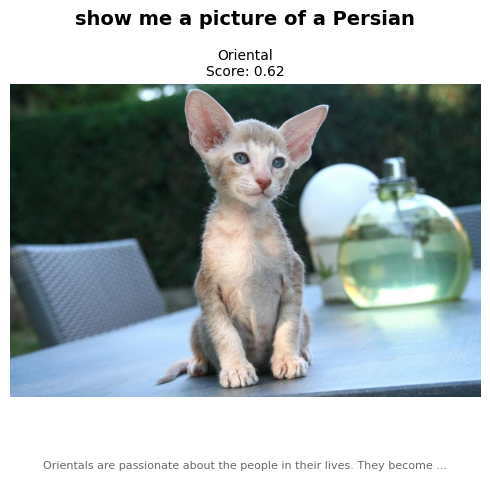

In [78]:
cat_qa.display()

### Bonus Section: Generate Similar Images using Gemini!

In [81]:
cat_generator = CatImageGeenerator(client=client)

In [90]:
for breed in predicted_breeds:
    cat_description = data[data.breed == breed].cat_description
    print(f'{breed}')
    print(f'{cat_description.iloc[0]}')

Scottish Fold
The Scottish Fold is a sweet, charming breed. She is an easy cat to live with and to care for. She is affectionate and is comfortable with all members of her family. Her tail should be handled gently. Folds are known for sleeping on their backs, and for sitting with their legs stretched out and their paws on their belly. This is called the "Buddha Position". Their temperament is described as Affectionate, Intelligent, Loyal, Playful, Social, Sweet, Loving. They are known to be very affectionate, tend to shed an average amount and can have health issues. They typically live around 12.5 years.
Persian
Persians are sweet, gentle cats that can be playful or quiet and laid-back. Great with families and children, they absolutely love to lounge around the house. While they don’t mind a full house or active kids, they’ll usually hide when they need some alone time. Their temperament is described as Affectionate, loyal, Sedate, Quiet. They are known to be very affectionate, tend t

In [ ]:
# Generate images in generated_images directory
new_image_dirs = []
for ix, breed in enumerate(predicted_breeds):
    cat_description = data[data.breed == breed].cat_description.iloc[0]

    prompt = f"Generate an image of a {breed} cat. Here is the description {cat_description}."
    image_data = cat_generator.generated_cat_images(prompt=prompt)
    breed_folder = f"generated_images/{breed}"

    if not os.path.exists(breed_folder):
        os.makedirs(breed_folder)

    if image_data:
        try:
            image = Image.open(BytesIO(image_data))
            filename = f"{breed.replace(' ', '_')}_{ix+1}.png"
            filepath = os.path.join(breed_folder, filename)
            image.save(filepath, "PNG")
            print(f" Generated and saved {filename} for {breed}")
            outpath = f'generated_images/{breed}/{filename}'
            new_image_dirs.append(outpath)

        except Exception as e:
            print(f" Error saving image for {breed} (image {ix+1}): {e}")

 Generated and saved Scottish_Fold_1.png for Scottish Fold
 Generated and saved Persian_2.png for Persian


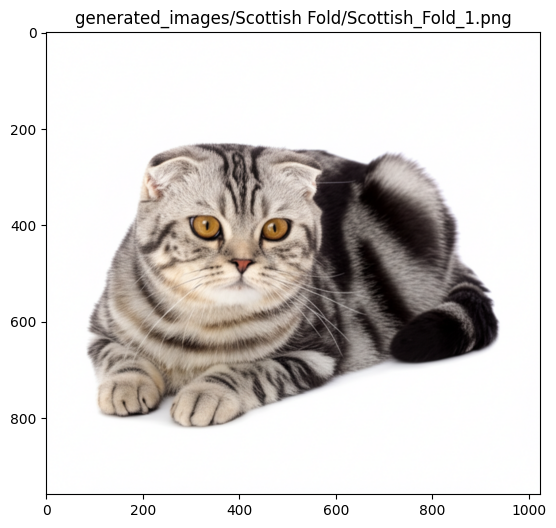

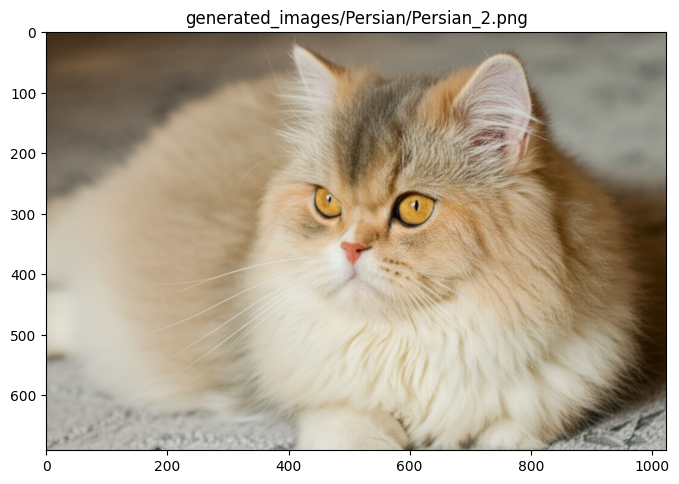

In [95]:
for img_pth in new_image_dirs:
    try:
        img = Image.open(img_pth).convert("RGB")
        fig, ax = plt.subplots(figsize = (8,6), facecolor="white")
        ax.imshow(img)
        ax.set_title(f"{img_pth}")
        plt.show(fig)
    except Exception as e:
        print(f"could not open {img_pth}: {e}")